# Data Visualisation

## Objectives

* Perform conventional data analysis on lemon dataset, returning visual plots 
* Identify visual markers that indicate a poor quality lemon

## Inputs

* Lemon quality dataset, split into train, validation, and test sets

## Outputs

* Visual plots for average images for both labels
* Plots of image variability for both labels
* Representing difference between average label data
* Image montage



---

# Import libraries

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

# Change working directory

Access current directory with os.getcwd()

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/lemon-qualitycontrol/jupyter_notebooks'


* os.path.dirname() gets the parent directory
* os.chdir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/lemon-qualitycontrol'

Set input directories


In [6]:
my_data_dir = 'inputs/lemon-quality-dataset/lemon_dataset'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

Set output directory

In [7]:
version = 'v2'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(current_dir) and version in os.listdir(current_dir + '/outputs'):
  print('Old version is already available, create a new version by changing version variable.')
  pass
else:
  os.makedirs(name=file_path)

Old version is already available, create a new version by changing version variable.


Set label names

In [8]:
labels = os.listdir(train_path)
print(f'Labels for the images are {labels}')

Labels for the images are ['bad_quality', 'good_quality']


---

# Data Visualisation of Image Data

Check image sizes

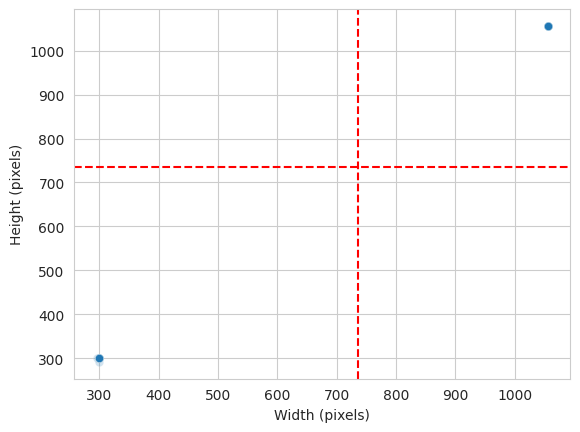

Width average: 736 
Height average: 736


In [9]:
dim1, dim2 = [], []
for label in labels:
  for image_filename in os.listdir(train_path + '/'+ label):
    img = imread(train_path + '/' + label + '/'+ image_filename)
    d1, d2, colors = img.shape
    dim1.append(d1) # image height
    dim2.append(d2) # image width

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean().round())
dim2_mean = int(np.array(dim2).mean().round())
axes.axvline(x=dim1_mean,color='r', linestyle='--')
axes.axhline(y=dim2_mean,color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

Reduce image dimensions to (50, 50) to improve speed of model training

In [10]:
image_shape = (50, 50, 3)
image_shape

(50, 50, 3)

Save image shape embeddings

In [11]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v2/image_shape.pkl']

Load images in tensor array

In [12]:
from tensorflow.keras.preprocessing import image

def load_image_as_array(my_data_dir, new_size: tuple, n_images_per_label: int):
  
  X, y = np.array([], dtype='int'), np.array([], dtype='object')
  labels = os.listdir(my_data_dir)

  for label in labels:
    counter = 0
    for image_filename in os.listdir(my_data_dir + '/' + label):
      # n_images_per_label: we set a limit, since it may take too much time
      if counter < n_images_per_label:
        
        img = image.load_img(my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
        if image.img_to_array(img).max() > 1: 
          img_resized = image.img_to_array(img) / 255
        else: 
          img_resized = image.img_to_array(img)
        
        X = np.append(X, img_resized).reshape(-1, new_size[0], new_size[1], img_resized.shape[2])
        y = np.append(y, label)
        counter += 1
        
  print(type(X))      
  return X, y #return type
  

Load images as array

In [13]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                          n_images_per_label = 30)
print(X.shape, y.shape)

<class 'numpy.ndarray'>
(60, 50, 50, 3) (60,)


---

## Plot and save mean and variability of images

In [14]:
from skimage import filters
def plot_mean_variability_per_labels(X, y, figsize: tuple, save_image: bool):

  for label_to_display in np.unique(y): #y values created as labels from last function
    sns.set_style("white")

    y = y.reshape(-1,1,1)
    boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
    arr = X[boolean_mask]

    avg_img = np.mean(arr, axis = 0)
    std_img = np.std(arr, axis = 0)
    avg_img_dominant = filters.sobel(avg_img)
    std_img_dominant = filters.sobel(std_img)
    print(f"==== Label {label_to_display} ====")
    print(f"Image Shape: {avg_img.shape}")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=figsize)
    axes[0,0].set_title(f"Average Image for label {label_to_display}")
    axes[0,0].imshow(avg_img, cmap='gray')
    axes[1,0].set_title(f"Variability image for label {label_to_display}")
    axes[1,0].imshow(std_img, cmap='gray')
    axes[0,1].set_title(f"Dominant features in average image for label {label_to_display}")
    axes[0,1].imshow(avg_img_dominant, cmap='gray')
    axes[1,1].set_title(f"Dominant features in image variability for label {label_to_display}")
    axes[1,1].imshow(std_img_dominant, cmap='gray')

    if save_image:
      plt.savefig(f"{file_path}/avg_var_{label_to_display}.png", bbox_inches='tight', dpi=150)
    else:
      plt.tight_layout()
      plt.show()
      print("\n")

==== Label bad_quality ====
Image Shape: (50, 50, 3)
==== Label good_quality ====
Image Shape: (50, 50, 3)


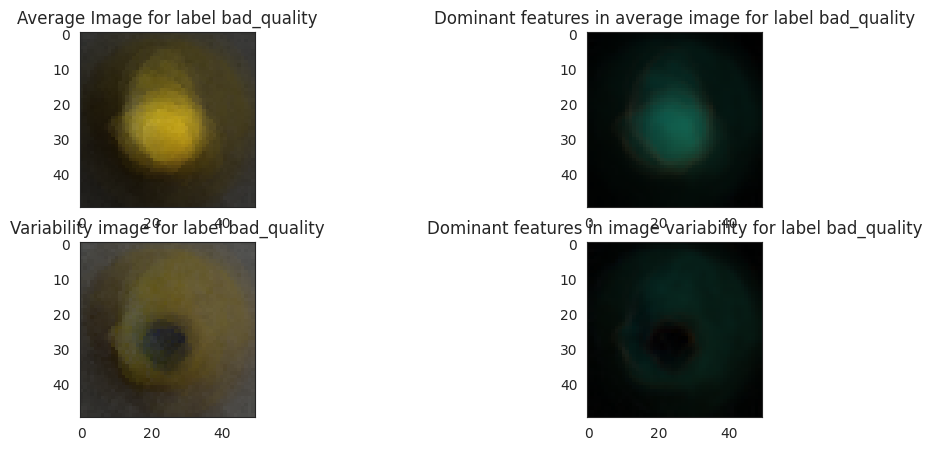

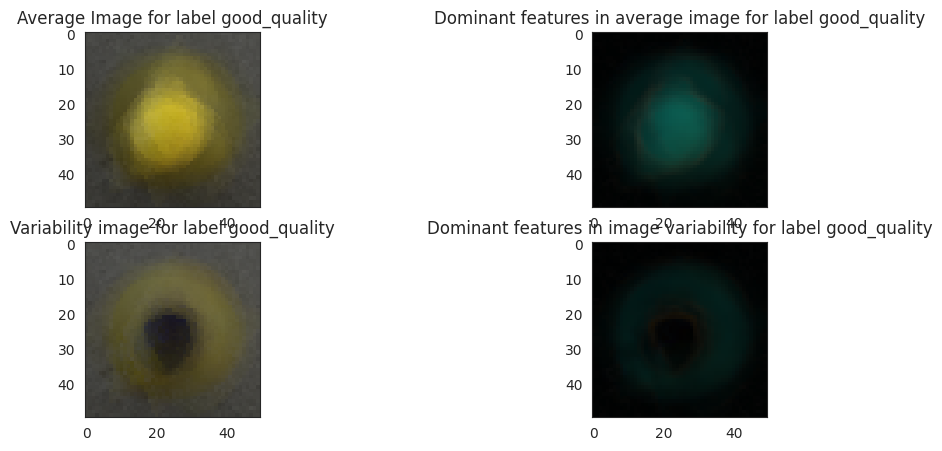

In [16]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12,5),save_image=True)

## Assess difference between average images of good and bad quality lemons

In [17]:
def subset_image_label(X,y,label_to_display): 
  y = y.reshape(-1,1,1)
  boolean_mask = np.any(y==label_to_display,axis=1).reshape(-1)
  df = X[boolean_mask]
  return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20,5), save_image=False):
  sns.set_style("white")

  if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
    print(f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
    return

  # calculate mean from label1
  images_label = subset_image_label(X, y, label_1)
  label1_avg = np.mean(images_label, axis = 0)

  # calculate mean from label2
  images_label = subset_image_label(X, y, label_2)
  label2_avg = np.mean(images_label, axis = 0)

  # calculate difference and plot difference, avg label1 and avg label2
  difference_mean = label1_avg - label2_avg
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
  axes[0].imshow(label1_avg, cmap='gray')
  axes[0].set_title(f'Average {label_1}')
  axes[1].imshow(label2_avg, cmap='gray')
  axes[1].set_title(f'Average {label_2}')
  axes[2].imshow(difference_mean, cmap='gray')
  axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
  if save_image:
    plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
  else:
    plt.tight_layout()
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


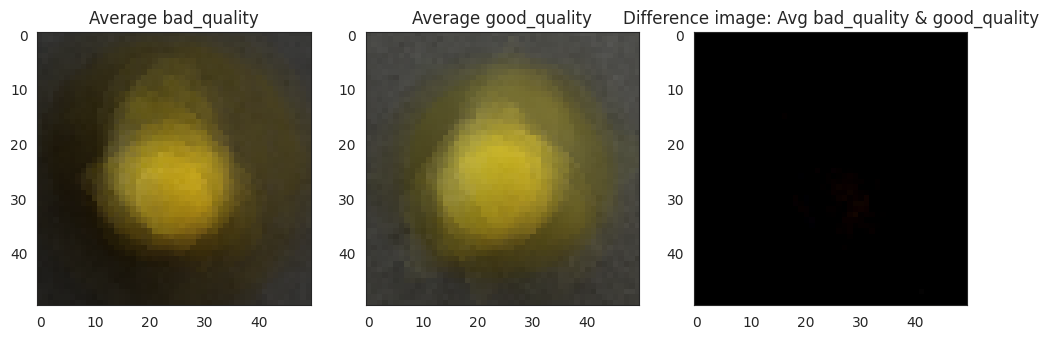

In [18]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='bad_quality', label_2='good_quality',
                                        figsize=(12,10),
                                        save_image=True
                                        )

---

## Create Image Montage

In [19]:
import itertools
import random
sns.set_style("white")

def image_montage(dir_path: str, label_to_display: str, nrows: int, ncols: int, figsize: tuple): 
  

  labels = os.listdir(dir_path)

  if label_to_display in labels:

    images_list = os.listdir(dir_path+'/'+ label_to_display)
    if nrows * ncols < len(images_list):
      img_idx = random.sample(images_list, nrows * ncols)
    else:
      print(
          f"Decrease nrows or ncols to create your montage. \n"
          f"There are {len(images_list)} in your subset. "
          f"You requested a montage with {nrows * ncols} spaces")
      return
    

    list_rows= range(0,nrows)
    list_cols= range(0,ncols)
    plot_idx = list(itertools.product(list_rows,list_cols))


    fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize=figsize)
    for x in range(0,nrows*ncols):
      img = imread(dir_path + '/' + label_to_display + '/' + img_idx[x])
      img_shape = img.shape
      axes[plot_idx[x][0], plot_idx[x][1]].imshow(img)
      axes[plot_idx[x][0], plot_idx[x][1]].set_title(f"Width {img_shape[1]}px x Height {img_shape[0]}px")
      axes[plot_idx[x][0], plot_idx[x][1]].set_xticks([])
      axes[plot_idx[x][0], plot_idx[x][1]].set_yticks([])
    plt.tight_layout()
    plt.show()


  else:
    print("The label you selected doesn't exist.")
    print(f"The existing options are: {labels}")


bad_quality


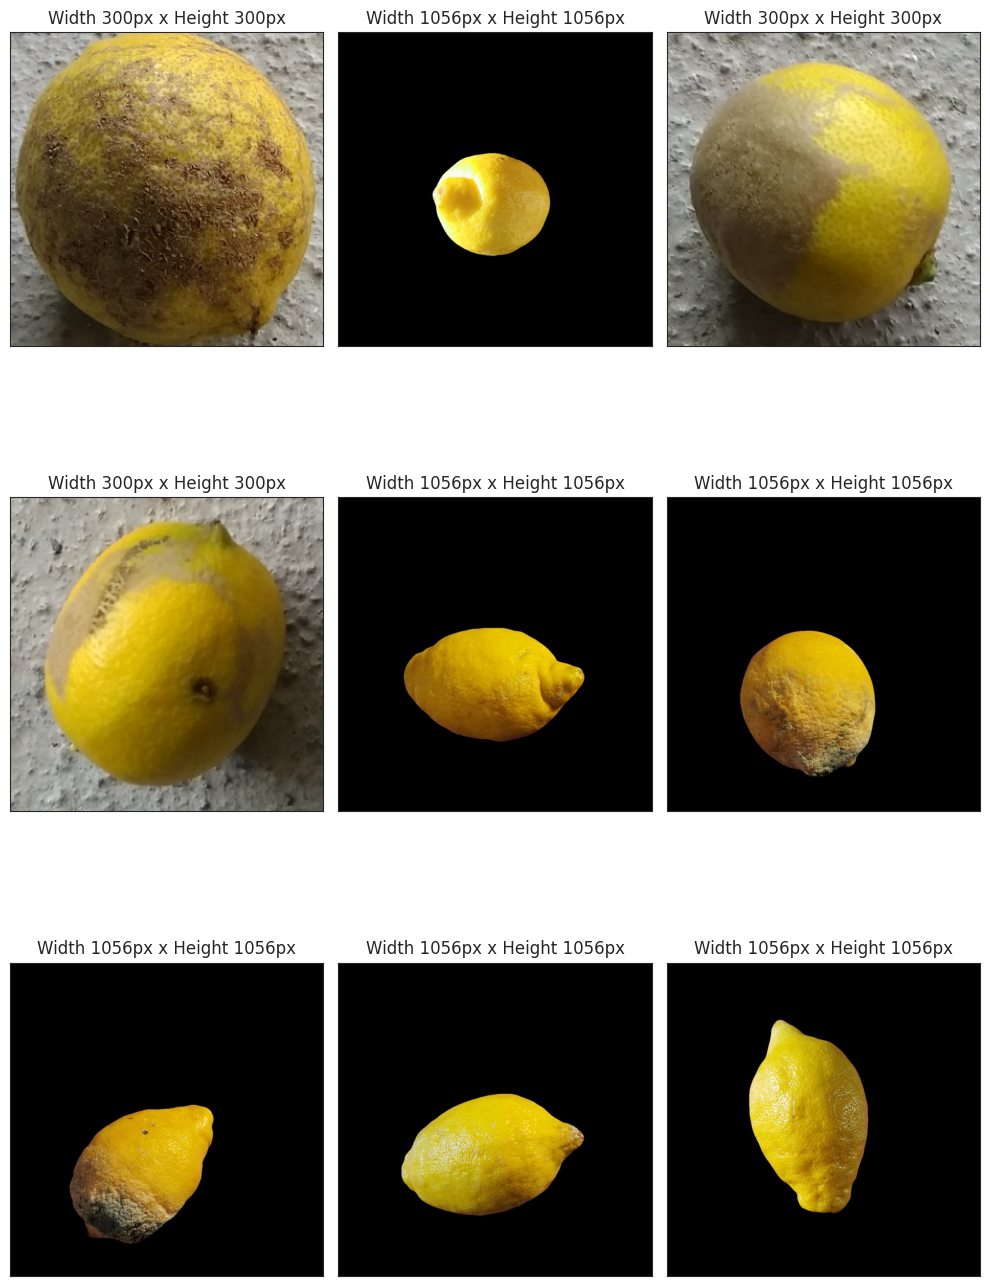



good_quality


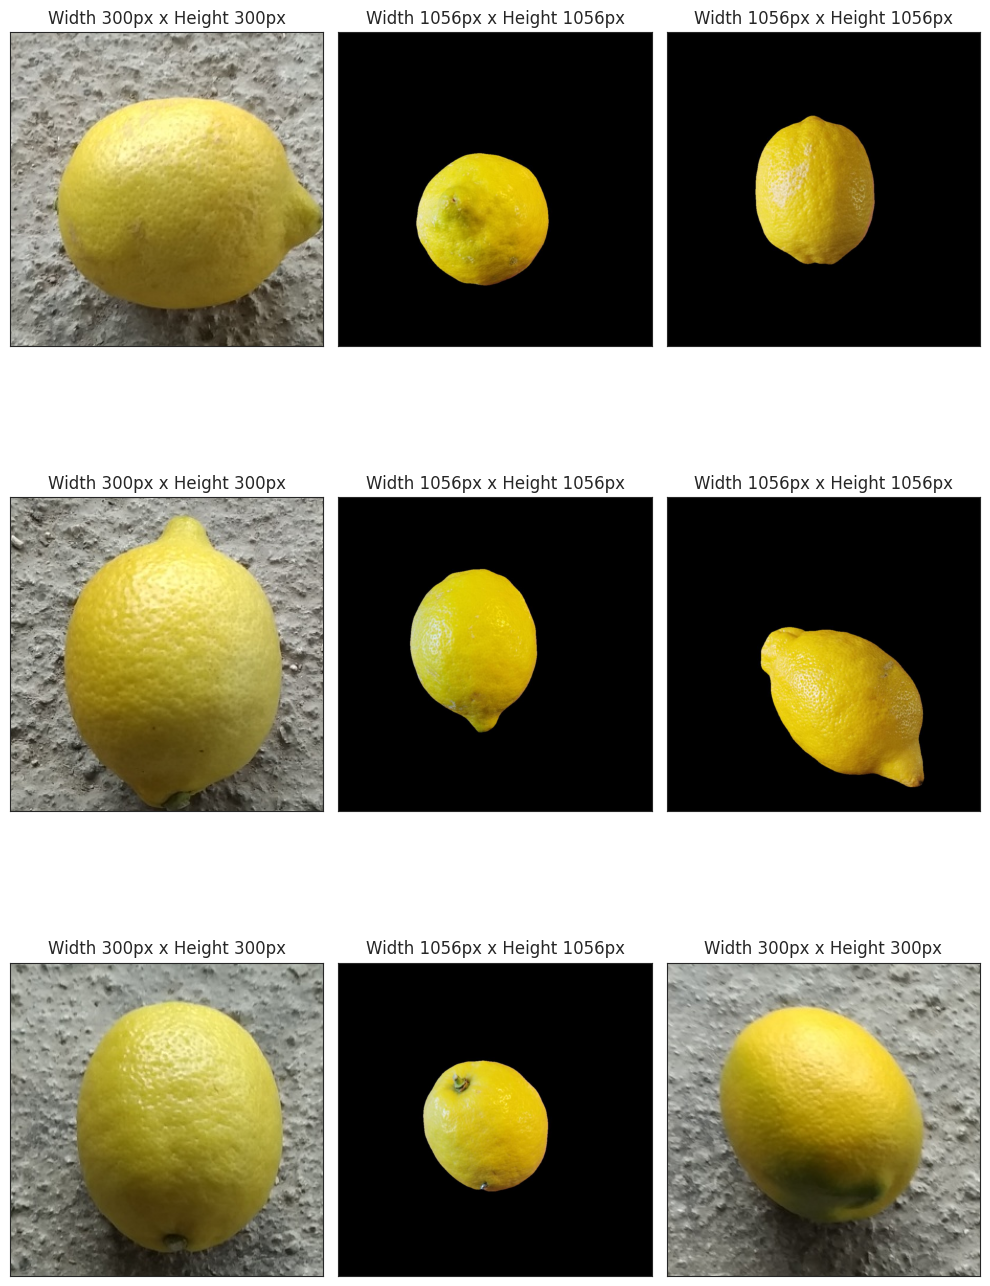

In [20]:
for label in labels:
  print(label)
  image_montage(dir_path= train_path,
                label_to_display= label,
                nrows=3, ncols=3,
                figsize=(10,15)
                )
  print("\n")